1、对于同一个星系，画出地面望远镜（SDSS or DESI）和空间望远镜（Hubble）的（尽量同一波段）fits图像的对比

• 采用相同的灰度（color bar）

• 定出星系的中心（流量最高点），计算其赤经赤纬

Text(0.5, 1.0, 'DESI NGC 5557')

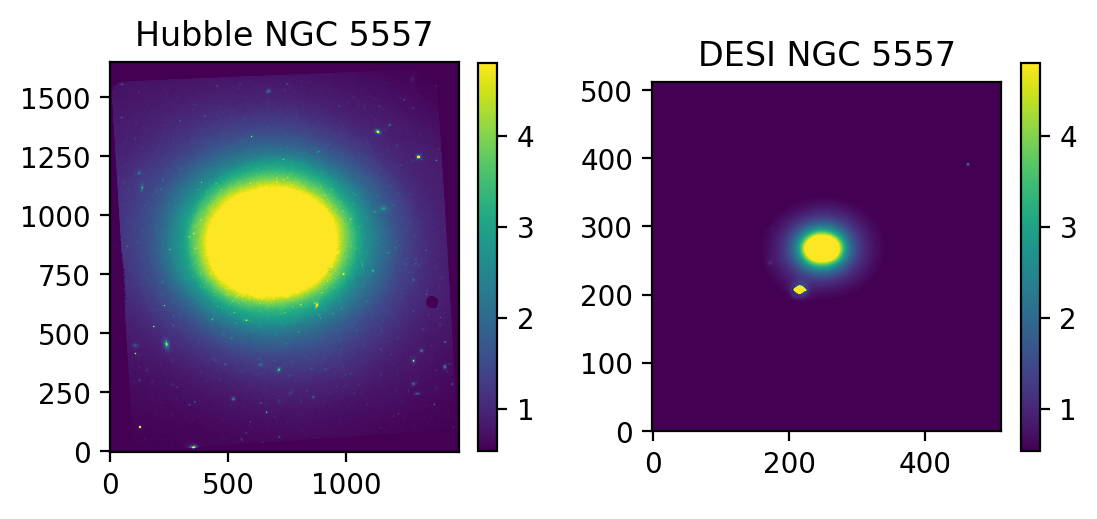

In [7]:
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.wcs import WCS

Hubble = fits.open('hst_14219_30_wfc3_ir_f110w_drz.fits')
DESI = fits.open('cutout_214.6066_36.4927.fits')

data_h = Hubble[1].data
data_d = DESI[0].data

plt.figure(figsize=(6,3), dpi=200)
plt.subplots_adjust(wspace=0.4)
plt.subplot(121)
plt.imshow(data_h, vmin=0.54, vmax=4.8, origin='lower')
plt.colorbar(fraction = 0.05)
plt.title('Hubble NGC 5557')

plt.subplot(122)
plt.imshow(data_d, vmin=0.54, vmax=4.8, origin='lower')
plt.colorbar(fraction = 0.05)
plt.title('DESI NGC 5557')

#Hubble选取的是F110W，DESI是z波段

# 画在相同空间坐标系下才会更直观

In [9]:
import numpy as np
def max_flux(fits_path, extension):
    im = fits.open(fits_path)
    i = extension

    data = im[i].data
    max_index = np.unravel_index(np.argmax(data), data.shape)
    y, x = max_index
    CRVAL1 = im[i].header['CRVAL1']
    CD1_1 = im[i].header['CD1_1']
    CRPIX1 = im[i].header['CRPIX1']
    CD1_2 = im[i].header['CD1_2']
    CRPIX2 = im[i].header['CRPIX2']
    CRVAL2 = im[i].header['CRVAL2']
    CD2_1 = im[i].header['CD2_1']
    CD2_2 = im[i].header['CD2_2']

    ra = CRVAL1 + CD1_1*(x-CRPIX1) + CD1_2*(y-CRPIX2)
    dec = CRVAL2 + CD2_1*(x-CRPIX1) + CD2_2*(y-CRPIX2)
    im.close()
    return (x,y), ra, dec

hubble_center_pixel, hubble_center_ra, hubble_center_dec = max_flux('hst_14219_30_wfc3_ir_f110w_drz.fits', 1)
DESI_center_pixel, DESI_center_ra, DESI_center_dec = max_flux('cutout_214.6066_36.4927.fits', 0)


In [10]:
print(hubble_center_pixel, hubble_center_ra, hubble_center_dec)
print(DESI_center_pixel, DESI_center_ra, DESI_center_dec)

(587, 713) 214.6091327503602 36.489039128526315
(208, 207) 214.6101297222222 36.4890975


1个本地（红移为0 ）重子物质为$10^{11}$Msun的星系，假设其物质密度分布为指数盘形式，指数盘的scale-length为3Kpc，该星系所在的暗物质晕的质量为$10^{12}$Msun，暗物质的物质密度轮廓服从NFW分布（c=10），该星系的运动为旋转的盘，请画出该星系的旋转曲线。

1. 重子物质的旋转速度
对于星系盘的质量分布，采用指数盘模型。星系盘的旋转速度公式为：
$$v_c^2(R) = 4\pi G\Sigma_0 R_d y^2 [I_0(y)K_0(y)-I_1(y)K_1(y)]$$

G是万有引力常数

$\Sigma_0$是中心面质量密度

$R_d$是星系盘的尺度长度

$y=\frac{R}{2R_d}$是无量纲半径

$I_n$，$K_n$是第n阶的改良贝塞尔函数

2. 暗物质晕的旋转速度
暗物质晕的质量分布使用NFW模型：
$$\rho(r)=\frac{\rho_{crit}\delta_0}{(r/r_s)(1+r/r_s)^2}$$
其中：

$r_s$是NFW晕的尺度半径，由晕的浓度参数$c$和$r_{200}$决定：$r_s=\frac{r_{200}}{c}$

$\rho_{crit}$是宇宙的临界密度

$\delta_0$是特征密度，与$c$和$r_{200}$有关

通过积分暗物质的质量分布，可以得到旋转速度：
$$v_{DM}(r)=\sqrt{\frac{GM(<r)}{r}}$$

其中$M(<r)$是半径$r$内的质量

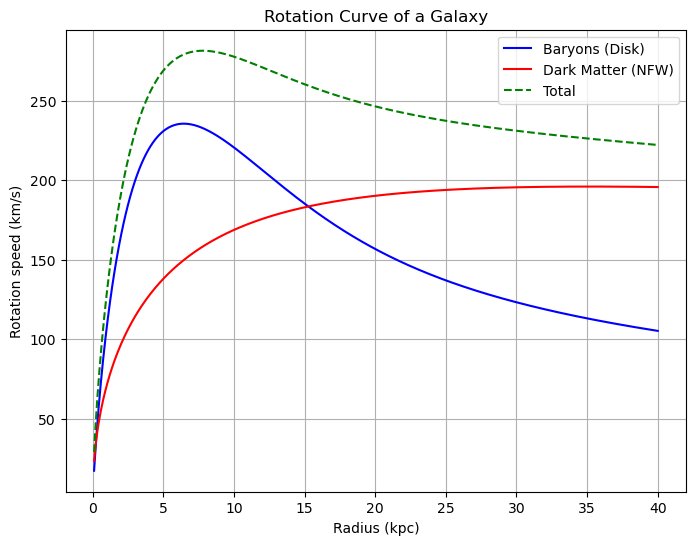

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import i0, i1, k0, k1

# 常量
G = 4.302e-6  # 万有引力常数 (kpc * km^2/s^2 / Msun)
Mbary = 1e11   # 星系质量，单位: Msun
Rd = 3  # 星系盘尺度长度 (kpc)

# NFW 暗物质晕参数
M_halo = 1e12  # 暗物质晕质量，单位: Msun
c = 10        # NFW浓度参数
r200 = 162.62  # r200 半径, 取近似值 (kpc)
rs = r200 / c  # NFW尺度半径 (kpc)

# 指数盘模型的旋转速度
def v_baryons(R, Sigma0, Rd):
    y = R / (2 * Rd)
    term1 = i0(y) * k0(y)
    term2 = i1(y) * k1(y)
    return np.sqrt(4 * np.pi * G * Sigma0 * Rd * y**2 * (term1 - term2))

# NFW暗物质晕模型的旋转速度
def v_dm(R, M_200, rs, c):
    rho_crit = 1e-2  # 临界密度 (任意单位)
    delta_0 = (200/3) * (c**3) / (np.log(1+c) - c/(1+c))
    x = R / rs
    M_r = M_halo * (np.log(1+x) - x/(1+x)) / (np.log(1+c) - c/(1+c))
    return np.sqrt(G * M_r / R)

# 计算旋转曲线
R = np.linspace(0.1, 40, 500)  # 半径范围 (kpc)
Sigma0 = Mbary / (2 * np.pi * Rd**2)  # 中心质量密度

v_b = v_baryons(R, Sigma0, Rd)
v_dm = v_dm(R, M_halo, rs, c)
v_total = np.sqrt(v_b**2 + v_dm**2)

# 绘制旋转曲线
plt.figure(figsize=(8, 6))
plt.plot(R, v_b, label="Baryons (Disk)", color='blue')
plt.plot(R, v_dm, label="Dark Matter (NFW)", color='red')
plt.plot(R, v_total, label="Total", color='green', linestyle='--')
plt.xlabel('Radius (kpc)')
plt.ylabel('Rotation speed (km/s)')
plt.legend()
plt.title('Rotation Curve of a Galaxy')
plt.grid(True)
plt.show()


对于Sersic指数分别是n=1，3，4的三个星系来
说，其R90/R50分别是多少？

In [17]:
from scipy.integrate import quad

def I(R, Rd, n, I0):
    return I0 * np.exp(-((R/Rd) ** (1/n)))

def integrate_intensity(n, I0, R_limit, Rd):
    integral, _ = quad(I, 0, R_limit, args=(Rd, n, I0))
    return integral

def R_k(n, I0, k, Rd):
    R_limit = 100  #kpc
    total_intensity = integrate_intensity(n, I0, R_limit, Rd)
    return (k * total_intensity) ** (1/n)  

def R50_R90_ratio(n, I0=1, Rd=3): #Rd=3kpc
    R50 = R_k(n, I0, 0.5, Rd)  # R50
    R90 = R_k(n, I0, 0.9, Rd)  # R90
    return R90 / R50


n_values = [1, 3, 4]
ratios = {n: R50_R90_ratio(n) for n in n_values}
ratios


{1: 1.8, 3: 1.21644039911468, 4: 1.158292185288269}

In [ ]:
# 没算对，积分积到哪里？